In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

from tetris import Tetris, rewards
from tetrismaster import TetrisMaster2

In [2]:
w, h = 10, 20
game_len = 50
epoch = 10000
betta = 0.3
gamma = 0.89
rf = 4
lr = 1e-5

In [3]:
game = Tetris(w, h)
game.clear_board(True)
# game.set_random_state()
model = TetrisMaster2(bw=w, bh=h).double()

# crit = lambda x: -torch.log(F.softmax(x, dim=0).prod() + eps)
crit = nn.NLLLoss()
# crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(TetrisMaster2.parameters(model), lr=lr)
best_loss = 99999
losses_e = []

In [ ]:
it = tqdm(range(0, epoch))
losses = []
for e in it:
    game.clear_board()
    optimizer.zero_grad()

    rwds = []
    probs_p = []
    probs_r = []
    
    done = False
    
    # collecting data loop
#     d = game.set_random_state()
    for t in range(game_len):
        x = torch.tensor(game.board - 1/2, dtype=torch.double).unsqueeze(0)
        yp, yr = model(x, torch.tensor(game.next, dtype=torch.double).view(1, 1))#[0]
        with torch.no_grad():
            col = np.random.choice(range(w), p=yp)
            rot = np.random.choice(range(4), p=yr)

            rp, rr = game.turn(col, rot)
            if rp <= rewards['lose_game_penalty']:
#                 game.print()
                d = game.set_random_state()
#                 break
                
        rwds.append((rp + rr + sum(rwds)) * gamma**t)
        probs_p.append(yp)
        probs_r.append(yr)
    probs_p = torch.stack(probs_p, dim=1)
    probs_r = torch.stack(probs_r, dim=1)
#     print(rwds)
#     print(probs_p.detach())
#     print(probs_r.detach())
#     if e == 1:
#         break

    loss  = torch.sum(-probs_p.log() * torch.tensor(rwds).view(1, -1))# + betta * torch.sum(-probs_p.log() * probs_p)
    loss += torch.sum(-probs_r.log() * torch.tensor(rwds).view(1, -1))# + betta * torch.sum(-probs_r.log() * probs_r)
#     loss *= 1e-4
#     print(probs_r)
#     print(loss.item())
    
    loss.backward()
    nn.utils.clip_grad_value_(model.parameters(), 5)
    optimizer.step()

    losses.append(loss.item()) 
    output = f'loss: {round(np.mean(losses), rf)} ' +\
        f'| reward: {round(np.sum(rwds), rf)}'
    it.set_postfix(str=output)

    if e % 200:
        best_loss = loss
        try:
            torch.save({
                'model_state_dict': model.state_dict(),
            }, 'checkpoints/test_model'.format(epoch, best_loss))
        except KeyboardIterrupt:
            torch.save({
                'model_state_dict': model.state_dict(),
            }, 'checkpoints/test_model'.format(epoch, best_loss))

print('Done!')

 74%|██████████████████████████████████████████████████████████                     | 7357/10000 [43:24<16:22,  2.69it/s, str=loss: 5.8473 | reward: 0.2824]

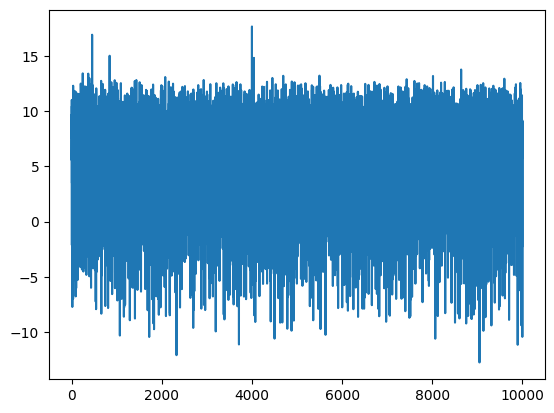

In [5]:
import matplotlib.pyplot as plt

plt.plot(losses)
# plt.show()